# Signal separation between amorphous and crystalline phases

This tutorial presents the various improvements in pyFAI since the initial signal separation which was described in https://doi.org/10.1017/S0885715613000924

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import time
import numpy
from matplotlib.pyplot import subplots
import fabio
import pyFAI

from pyFAI.gui import jupyter
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
from silx.resources import ExternalResources

start_time = time.perf_counter()
downloader = ExternalResources("pyfai", "http://www.silx.org/pub/pyFAI/testimages")
image_file = downloader.getfile("Pilatus6M.cbf")
geometry_file = downloader.getfile("Pilatus6M.poni")

fimg = fabio.open(image_file)
img = fimg.data
print(f"Using pyFAI version {pyFAI.version}")

Using pyFAI version 2025.3.0


In [3]:
ai = pyFAI.load(geometry_file)
print(ai)

Detector Pilatus 6M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033200e-10 m
SampleDetDist= 3.000000e-01 m	PONI= 2.254060e-01, 2.285880e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 300.000 mm	Center: x=1329.000, y=1310.500 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.033Å


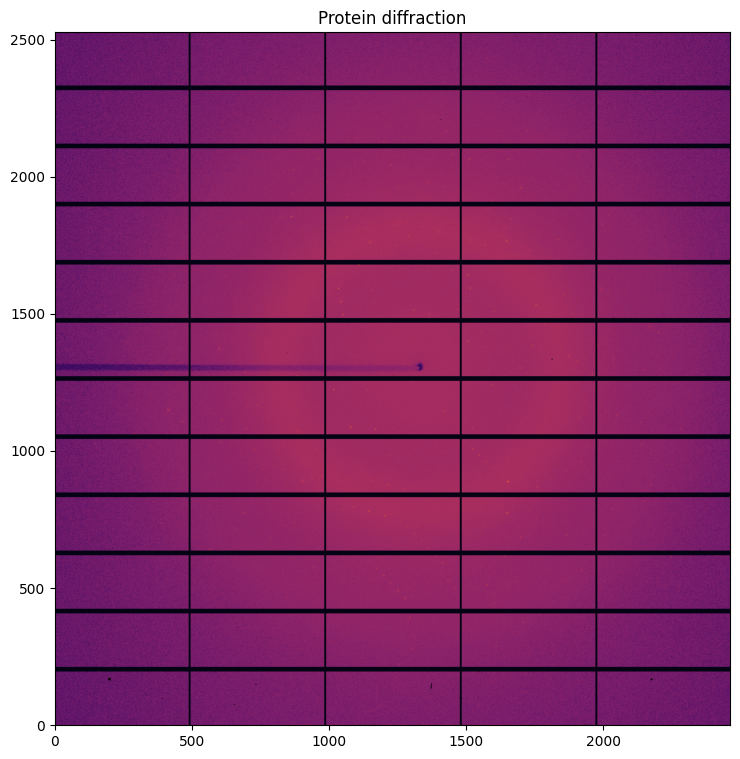

In [4]:
# Visualization of a proetein single crystal diffraction, containing both background and Bragg-peaks
fig,ax = subplots(figsize=(9,9))
jupyter.display(img, ax=ax, label="Protein diffraction")
pass

## 0. 1D and 2D integration

Simple visualization of the 1D and 2D integrated data. Observe the smooth background and the sharp peaks comming from the single crystal.

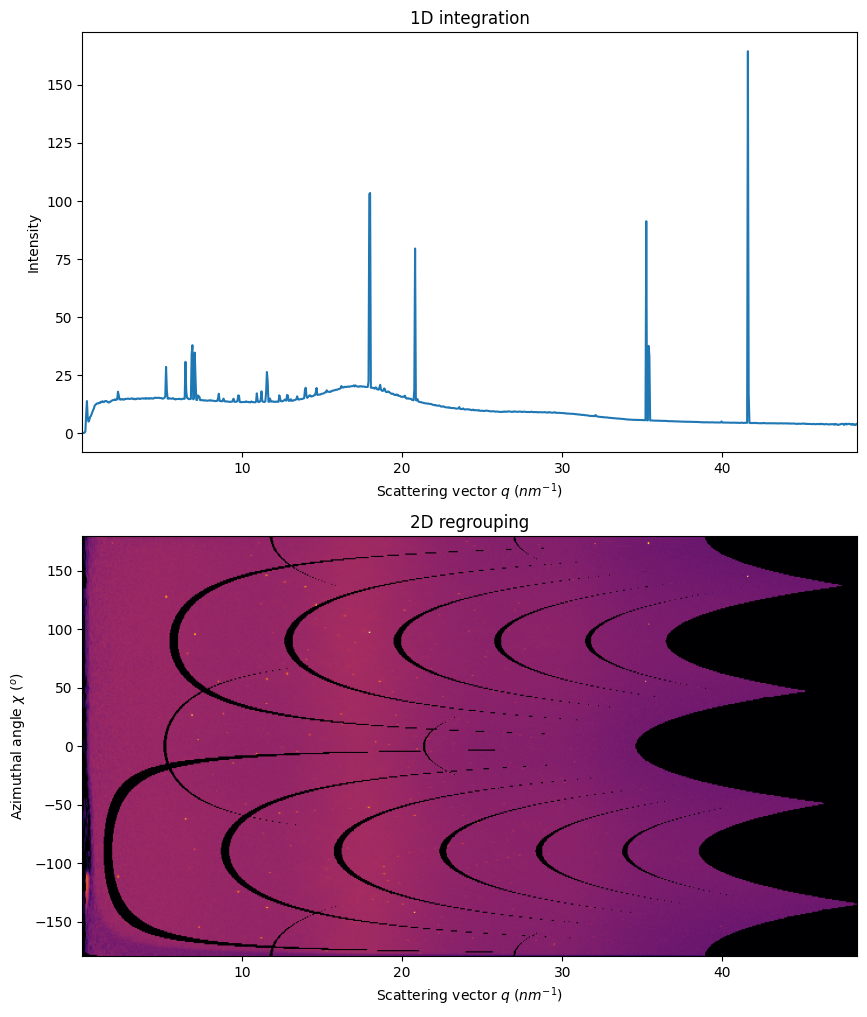

In [5]:
fig,ax = subplots(2, figsize=(10,12))
method=("full","csr","cython")
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax[0])
int2 = ai.integrate2d(img, 1000, method=method)
jupyter.plot2d(int2, ax=ax[1])
ax[0].set_xlim(int2.radial.min(), int2.radial.max())
pass

## 1. Separation based on 2D integration

Two methods are readily available in pyFAI, they perform filtering the 2D regrouped image along a vertical axis:
* median filtering: simple median along azimuthal angle (described in the before-mentionned article from 2013)
* sigma clipping: iterative removal of all pixels above n standard deviation, this enforces a normal distribution

The drawback is in the initial 2D integration: costly in time on the one hand and smears pixel signal on the other.

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/jerome/.venv/py311/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/jerome/.venv/py311/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/jerome/.venv/py311/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/home/jerome/.venv/py311/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/jerome/.venv/p

CPU times: user 2.27 s, sys: 187 ms, total: 2.46 s
Wall time: 1.91 s
CPU times: user 653 ms, sys: 0 ns, total: 653 ms
Wall time: 74.3 ms


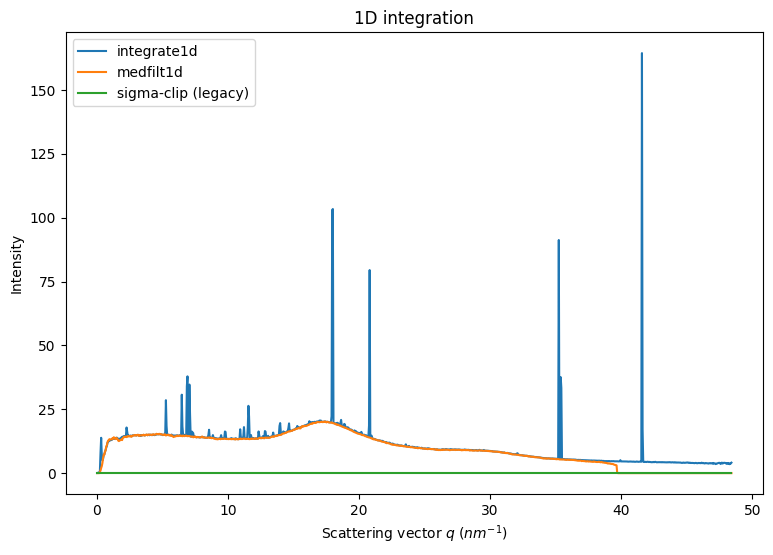

In [6]:
fig,ax = subplots(1,1, figsize=(9,6))
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax, label="integrate1d")
%time mf1 = ai.medfilt1d(img, 1000, method=method)
%time sc2 = ai.sigma_clip(img, 1000, method=method, thres=5, max_iter=5)
ax.plot(mf1.radial, mf1.intensity, label="medfilt1d")
ax.plot(sc2.radial, sc2.intensity, label="sigma-clip (legacy)")
ax.legend()
pass

## 2. Separation based on 1D integration:

1D CSR integrator contain all the information to perform the sigma-clipping. 
This has been implemented in OpenCL and can be performed up to thousands of times per second on modern/high-end GPU.

* Available using Cython and OpenCL. Python implementation gives slightly different answers
* Pixel splitting is not recommanded since a single pixel can belong to multiple bins and being discarded.

CPU times: user 769 ms, sys: 44.7 ms, total: 814 ms
Wall time: 428 ms
CPU times: user 344 ms, sys: 31.6 ms, total: 376 ms
Wall time: 378 ms


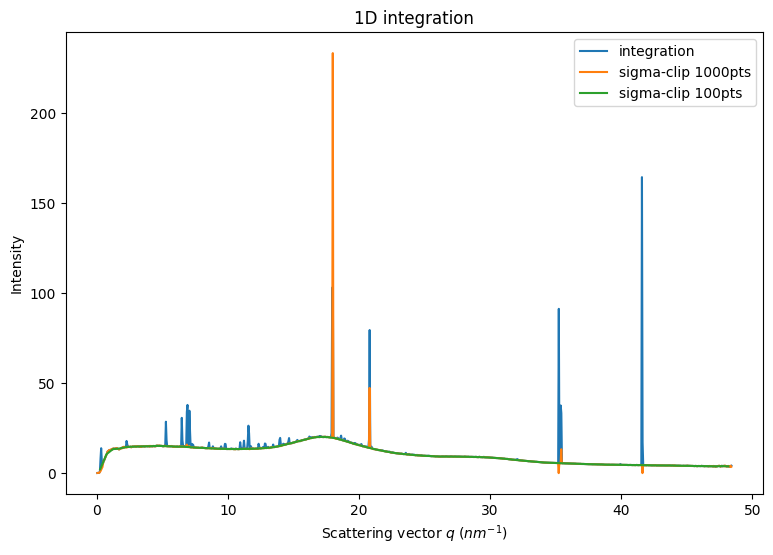

In [7]:
fig,ax = subplots(1,1, figsize=(9,6))
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax, label="integration")
method=("no","csr","opencl")
%time sc1000 = ai.sigma_clip_ng(img, 1000, method=method, thres=5, max_iter=5, error_model="poisson")
%time sc100 = ai.sigma_clip_ng(img, 100, method=method, thres=5, max_iter=5, error_model="poisson")
ax.plot(sc1000.radial, sc1000.intensity, label="sigma-clip 1000pts")
ax.plot(sc100.radial, sc100.intensity, label="sigma-clip 100pts")
ax.legend()
pass

Note that with many bins (1000), the outlier removal can provide completely nuts results, either empty bins, or high intensity bins. 
This is due to the small size of the ensemble for a bin and the poor initial statistics, not following the Poisson statistics. 

## 3. Rebuild the isotropic and anisotropic contribution

Isotropic images are simply obtained from bilinear interpolation from 1D curves.

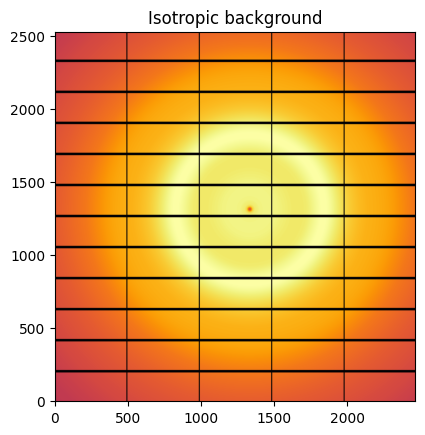

In [8]:
# Rebuild an image from the integrated curve:
isotropic = ai.calcfrom1d(sc100.radial, sc100.intensity, dim1_unit=sc100.unit, mask = ai.detector.mask)
jupyter.display(isotropic, label="Isotropic background")
pass

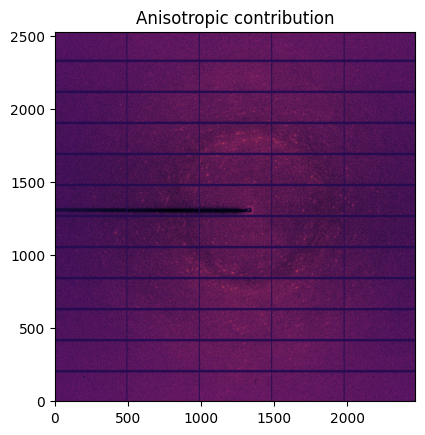

In [9]:
aniso = img - isotropic
jupyter.display(aniso, label="Anisotropic contribution")
pass

In [10]:
#This can be simplified (using median filtering)
bragg, amorphous = ai.separate(img)

fig,ax = subplots(1, 2, figsize=(9,6))
jupyter.display(bragg, label="Bragg", ax=ax[0])
jupyter.display(amorphous, label="Amorphous", ax=ax[1])
pass

ValueError: Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead.

Note: The polarization effect was not accounted for in this demonstration and one can see more peaks along the vertical direction and less along the horizontal direction in the left-hand side image. Polarization correction is implemented with the keyword `polarization_factor=0.99`

## 4. Implementation of sigma-clipping using pure 1D integrators.

This is a example of how to implement sigma-clipping with former version of pyFAI (<0.21)

In [ ]:
def sigma_clip_ng(ai, img, npt, method, unit="q_nm^-1", error_model=None, thres=5, max_iter=5):
    img = img.astype(numpy.float32) #also explicit copy
    if error_model!="poisson":
        raise RuntimeError("Only Poissonian detector are supported for now")
    for i in range(max_iter):
        variance = img #enforce Poisson lay
        res1d = ai.integrate1d(img, npt, variance=variance, method=method, unit=unit)
        new_signal = ai.calcfrom1d(res1d.radial, res1d.intensity, dim1_unit=res1d.unit)
        new_variance = ai.calcfrom1d(res1d.radial, res1d.intensity, dim1_unit=res1d.unit)
        discard = abs(img-new_signal)>thres*new_variance
        if discard.sum() == 0: break
        img[discard] = numpy.nan
    return res1d

In [ ]:
fig,ax = subplots(1,1, figsize=(9,6))
method = ("no","csr","cython")
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax, label="integrate1d")
%time sc1000 = sigma_clip_ng(ai, img, 1000, method=method, thres=5, max_iter=5, error_model="poisson")
%time sc100 = sigma_clip_ng(ai, img, 100, method=method, thres=5, max_iter=5, error_model="poisson")
ax.plot(sc1000.radial, sc1000.intensity, label="sigma-clip 1000pts")
ax.plot(sc100.radial, sc100.intensity, label="sigma-clip 100pts")
ax.legend()
pass

## 5. Variance assessement from deviation to the mean

Poissonian noise expects the variance to be $ \sigma^2 = <I> $

We have seen in section 2 that the assumption of a *Poissonian* noise can lead to empty bins when the distribution of pixel intensities is spread over a wider extent the estimated uncertainty. This is jeoparizes any for subsequent processing.

An alternative is to consider the variance in the azimuthal bin: $ \sigma^2 = < (I - <I>)^2 > $

This is obtained with the keyword `error_model='azimuthal'`:

In [ ]:
fig,ax = subplots(1,1, figsize=(9,6))
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax, label="integrate1d")
method=("no","csr","cython")
%time sc1000 = ai.sigma_clip_ng(img, 1000, method=method, thres=0, max_iter=5, error_model="azimuthal")
%time sc100 = ai.sigma_clip_ng(img, 100, method=method, thres=0, max_iter=5, error_model="azimuthal")
ax.plot(sc1000.radial, sc1000.intensity, label="sigma-clip 1000pts")
ax.plot(sc100.radial, sc100.intensity, label="sigma-clip 100pts")
ax.legend()
pass

Note that all artifacts are now gone.

## 6. Towards lossy compression of single crystal diffraction data

For now only available as OpenCL code. 

Also available as command line tool, see `man sparsify-Bragg`:

This 6 Mpix image can be summarized by:
* 2000 pixels with signal above the background
* 100 radial bins with intensity and associated deviation

In [ ]:
from pyFAI.opencl.peak_finder import OCL_PeakFinder
method = sc100.method
print(method)
lut = ai.engines[method].engine.lut
#print(lut) # this is the stored transformation matrix
peak_finder = OCL_PeakFinder(lut, 
                             image_size=numpy.prod(ai.detector.shape),
                             unit=sc100.unit,
                             bin_centers=sc100.radial,
                             radius=ai.array_from_unit(sc100.unit),
                             mask=ai.detector.mask)

%time sep = peak_finder(img, error_model="azimuthal")
print(f"Number of Bragg pixels found: {len(sep.index)}")

In [ ]:
%%time
# Rebuild the image with noise
bg_avg = ai.calcfrom1d(sep.radius, sep.background_avg, dim1_unit=sc100.unit)
bg_std = ai.calcfrom1d(sep.radius, sep.background_std, dim1_unit=sc100.unit)
restored = numpy.random.normal(bg_avg, bg_std)
restored[numpy.where(ai.detector.mask)] = -1
restored_flat = restored.ravel()
restored_flat[sep.index] = sep.intensity
restored = numpy.round(restored).astype(numpy.int32)

In [ ]:
fig,ax = subplots(1, 2, figsize=(9,6))
jupyter.display(img, label="Original", ax=ax[0])
jupyter.display(restored, label="Restored", ax=ax[1])
pass

In [ ]:
raw_size = img.nbytes
cmp_size = sep.index.nbytes + sep.intensity.nbytes + sep.background_avg.nbytes + sep.background_std.nbytes
print(f"The compression ratio would be : {raw_size/cmp_size:.3f}x")

Note the disaprearance of the beam-stop shadow in the restored image. 
Thus. masks need to be handled precisely.

## 7. Conclusion

This tutorial explains how single crystal diffraction images can be treated to separate the amorphous content from Bragg peaks.
The first method has extensively been described in `J Kieffer & J.P. Wright; Powder Diffraction (2013) 28 (S2), pp339-350`
Subsequent ones have been developed with Gavin Vaughan (ESRF ID15) and Daniele De Sanctis (ESRF ID29).
Those methods open the door to lossy compression in the world of single crystal diffraction with compression rates above 100x which makes them appealing for serial-crystallography applications where bandwidth is critical. 
First experimentation shows a limited degradation of the signal (around  0.2% in Rint).

In [ ]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s ")